In [1]:
from model import *
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Remove logging messages in terminal
from time import time

import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Dropout, AlphaDropout, Lambda, Attention
from tensorflow.keras.layers import GlobalAveragePooling2D, Multiply, Permute, Reshape, Conv1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib import style

from scipy.stats import norm #For our active learning algorithm

#We will use sklearn to create our Gaussian Process
import sklearn.gaussian_process as gp

#Load Data
model_input = np.load("sparse_model_input.npy")
expert_policy = np.load("sparse_expert_policy.npy")
state_value = np.load("sparse_state_value.npy")
lengths = np.load("sparse_lengths.npy")

In [2]:
#Meta analysis of expert games
games = len(lengths)
print("Number of Expert Trajectories: ", games)
avg_length = np.mean(lengths)
print("Average Trajectory Length: ", avg_length)
print("Examples: ", avg_length*games)

Number of Expert Trajectories:  33959
Average Trajectory Length:  118.66144468329456
Examples:  4029624.0


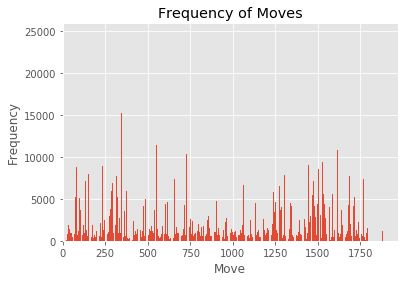

In [25]:
#Analysis of Policies
plt.style.use('ggplot')
unique = np.unique(expert_policy, return_counts=True) #sum of onehot vectors will give us a histogram
policy_freq = np.zeros(1968)
for index in range(len(unique[0])):
    policy_freq[unique[0][index]] = unique[1][index]

plt.bar(np.arange(1968), policy_freq)
plt.title("Frequency of Moves")
plt.xlim([0, 1968])
plt.ylim([0, np.max(policy_freq)])
plt.xlabel("Move")
plt.ylabel("Frequency")
plt.savefig("figures/FrequencyofMoves.png")
plt.show()


In [16]:
#Show which moves never show up in the dataset
import env

index = 0
for move_num in policy_freq:
    if move_num == 0:
        print(env.MOVES[index])
    index += 1

a7b8r
b7a8n
b7c8b
c7b8n
d7c8b
d7c8n
d7e8b
e7d8b
e7d8n
e7f8b
f7e8b
f7g8b
f7g8n
g7h8r
g7h8n
h7g8b
h7g8n
a2b1r
a2b1n
b2c1b
c2b1r
c2b1n
c2d1b
d2e1r
e2d1r
e2d1n
e2f1b
f2e1b
f2e1n
f2g1b
g2f1b
g2f1n
g2h1r
g2h1b
g2h1n
h2g1n


In [17]:
#Show which moves show up frequently in the dataset
import env

index = 0
for move_num in policy_freq:
    if move_num > 10000:
        print(env.MOVES[index])
    index += 1

a1c1
e1g1
f1e1
f1e2
f1g2
g1g2
a2a3
b2b3
e2e3
f2f3
f2f4
g2g3
h2h3
e3e4
f3e5
g3g4
h3h4
a4a5
c4d5
h4h5
a5a4
c5d4
h5h4
a6a5
e6d5
e6e5
g6g5
h6h5
a7a5
a7a6
b7b6
e7e6
f7f6
g7g6
h7h6
a8c8
b8c6
b8d7
e8g8
f8e7
f8e8
g8g7


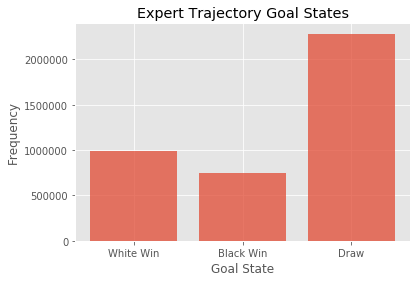

White Win %:  24.664112582216106
Black Win %:  18.645213548460106
Draw %:  56.69067386932379


In [28]:
#Analysis of Rewards
plt.style.use('ggplot')

white = 0
black = 0
draw = 0
for val in state_value:
    if val < 0:
        black += 1
    elif val > 0:
        white += 1
    else:
        draw += 1

plt.bar(["White Win", "Black Win", "Draw"], [white, black, draw], alpha=0.75)
plt.title("Expert Trajectory Goal States")
plt.xlabel("Goal State")
plt.ylabel("Frequency")
plt.savefig("figures/ExpertTrajectoryGoalStates.png")
plt.show()
print("White Win %: ", 100*white/(white + black + draw))
print("Black Win %: ", 100*black/(white + black + draw))
print("Draw %: ", 100*draw/(white + black + draw))


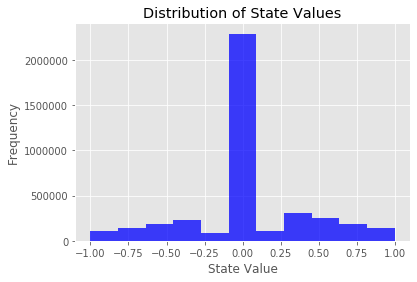

Average State Value:  0.032584294176694624


In [27]:
#Histogram of actual distribution
plt.hist(state_value, bins=11, color="blue", alpha=0.75)
plt.title("Distribution of State Values")
plt.xlabel("State Value")
plt.ylabel("Frequency")
plt.savefig("figures/DistributionofStateValues.png")
plt.show()

print("Average State Value: ", np.mean(state_value))